# Sistema de Navegación Inteligente de un Hexápodo para la Evasión de Obstaculos (SINHEO)

<img src="img/sinheo_logo.png" width="250"/>

## Cinemática Inversa para el Hexapodo
Este documento contiene el progreso de la Interfaz Gráfica de Usuario (GUI) construida en Python 3 para generar y visualizar los movimientos de un robot Hexapodo a partir de sus dimensiones y especificaciones del usuario.

Inicialmente utilizaremos el modulo **Tkinter**, el cual es una biblioteca gráfica **Tcl/Tk** de Python para realizar nuestra GUI. Para ello, debemos conocer ciertos conceptos básicos los cuales se ilustraran con el siguiente ejemplo:


In [1]:
import tkinter as tk

# Testing window that display the current version of Tkinter
# tk._test()

# Read the whole documentation at http://effbot.org/tkinterbook/tkinter-index.htm

# To initialize Tkinter, we create a Tk root widget (an ordinary window).
root = tk.Tk()
# We create a label widget as child to the root window.
theLabel = tk.Label(root, text="This is too easy")
# We call the pack method on this widget. This tells it to size itself to fit the given text, and make itself visible.
theLabel.pack()
# We display the window using the Tkinter event loop. The program will stay in the event loop until we close the window
root.mainloop()

Inicialmente, se importa el módulo Tkinter con el alias **tk** a tráves de la siguiente línea de código:

```python
import tkinter as tk
```

Toda GUI en Tkinter necesita de una ventana raíz o *root* donde visualizar los otros componentes hijos o _widgets_ para nuestra aplicación. En este ejemplo, creamos un elemento de tipo *label*, el cual puede mostrar tanto textos como iconos o alguna otra imagen. Para este caso, especificamos que es un texto y a su vez al componente madre al que pertenece, _root_.

Luego llamamos el método `.pack()` en nuestro elemento para autoajustar su tamaño en función del texto y hacerlo visible. Aún así, no se visualizará nada debido hasta no ejecutar el **ciclo de eventos Tkinter**, el cual se encarga de manejar cualquier acción del usuario con la interfaz (clic, teclear, mensajes, etc).

## Definición de los marcos de referencia y modelos cinemáticos

### Marco de referencia global
El marco de referencia global para está simulación estará ubicado en una de las esquinas de la simulación (o terreno), el cual denotaremos por la letra **G** en todas nuestras notaciones. Además, los ejes de este marco de referencia global seguirán la regla de la mano derecha. 

### Marco de referencia para el cuerpo (_Trunk_)
En el caso de la araña, se sitúa el origen de los ejes coordenados a la misma altura del panel inferior del robot, ubicandose en su centro geométrico. Se toma la denotación de los giros en los ejes **x - y - z** como **roll - pitch - yaw**, siendo estos relativos al marco de referencia global. En base a ello, las respectivas matrices de rotación se muestrán en las siguientes ecuaciones con sus respectivos ángulos:
 
<img src="img/roll-pitch-and-yaw-angles.png" width="300"/>


\begin{align}
Roll: R_x(\gamma) = 
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & cos(\gamma) & -sin(\gamma) \\
    0 & sin(\gamma) & cos(\gamma) 
\end{bmatrix}
,\
Pitch: R_y(\beta) =
\begin{bmatrix}
    cos(\beta) & 0 & sin(\beta) \\
    0 & 1 & 0 \\
    -sin(\beta) & 0 & cos(\beta)
\end{bmatrix}
,\
Yaw: R_z(\alpha) =
\begin{bmatrix}
    cos(\alpha) & -sin(\alpha) & 0 \\
    sin(\alpha) & cos(\alpha) & 0 \\
    0 & 0 & 1 
\end{bmatrix}
\end{align}

### Definición de los paramétros Denavit - Hartenberg para la cinemática de una pata.
Basandonos en la convención Denavit - Hartenberg para describir la geometria de una cadena cinemática / manipulador robótico; los cuales se definen en la tabla de abajo, podemos obtener el modelo cinemático para una pata. Las notaciones para cada eslabón (o servo) están basadas en los insectos, siendo el primer servo (Une el cuerpo con la pata) denominado ***Coxa***, el segundo servo ***Femur*** y el último servo ***Tibia***.

| Parametro | Definición |
| :---: | :---: |
| $\theta_{\mathrm{i}}$ | Es el ángulo comprendido entre los ejes $x_{\mathrm{i - 1}}$ y $x_{\mathrm{i}}$, medido en torno al eje $z_{\mathrm{i - 1}}$, en el sentido de la regla de la mano derecha. |
| $\mathrm{d_i}$ | Es la desviación del eslabón, es decir, la distancia comprendida desde el eje $x_{\mathrm{i - 1}}$ al eje $x_{\mathrm{i}}$ a lo largo del eje $z_{\mathrm{i - 1}}$. |
| $\mathrm{a_i}$	| Es la longitud cinemática del eslabón, es decir, la distancia entre el eje $z_{\mathrm{i - 1}}$ y el $z_{\mathrm{i}}$ a lo largo del eje $x_{\mathrm{i}}$ |
| $\alpha_{\mathrm{i}}$ | Es el ángulo comprendido entre los ejes $z_{\mathrm{i - 1}}$ y $z_{\mathrm{i}}$, medido en torno al eje $x_{\mathrm{i}}$, en sentido de la regla de la mano derecha. |

La obtención de los parametros se realiza siguiendo los pasos de la metodologia en la figura siguiente, con la visualización de cada eje coordenado, rotaciones y la tabla resumiendo los valores / variables del modelo cinemático.

| Eslabón | $\theta_{\mathrm{i}}$ | $\mathrm{a_i}$ | $\mathrm{d_i}$ | $\alpha_{\mathrm{i}}$ |
| :---: | :---: | :---: | :---: | :---: |
| 1 | $\theta_1$ | $\mathrm{L_1}$ | $\mathrm{d_L}$ | $\pi/2$ |
| 2 | $\theta_2$ | $\mathrm{L_2}$ | 0 | $\pi$ |
| 3 | $\theta_3$ | $\mathrm{L_3}$ | 0 | 0 |

#### 1. Importación de modulos / librerias de Python

In [1]:
# Importamos la librerias de Numpy y SymPy
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import math

#### 2. Definición de simbolos

In [2]:
# Impresión en formato latex para las ecuaciones de la libreria SymPy.
init_printing(use_latex='mathjax')

# Simbolos generales para las matrices, ángulos y variables.
alpha, beta, gamma = symbols('alpha beta gamma')
g_k, r_c, theta_i, alpha_i, a_i, d_i = symbols('gamma_k r_c theta_i alpha_i a_i d_i')
# Simbolos especificos.
# Ángulos de los servos (variables)
t_1, t_2, t_3 = symbols('theta_1 theta_2 theta_3')
# Longitud de los eslabones de las patas.
L_1, L_2, L_3, d_L = symbols('L_1 L_2 L_3 d_L')
# Esta es la traslación desde el origen coordenadas globales hasta el centro del robot.
X_t, Y_t, Z_t = symbols('X_t Y_t Z_t')
# Coordenadas de origen de una pata
x_l, y_l, z_l = symbols('x_l y_l z_l')

#### 3. Matrices de rotación / traslación globales y locales

In [3]:
# Matrices de rotación alrededor de cada eje con sus variables
RotMatrX = rot_axis1(gamma).T
RotMatrY = rot_axis2(beta).T
RotMatrZ = rot_axis3(alpha).T
# Matriz de rotación completa (Roll -> Pitch -> Yaw) o "balance, cabeceo, guiñada"
RotMatrRPY = RotMatrZ*RotMatrY*RotMatrX
# Matriz homogénea de transformación de cuerpo a coordenadas globales (B -> G)
TransfMatrRPY = RotMatrRPY.col_insert(3, Matrix([X_t, Y_t, Z_t])).row_insert(3, Matrix([[0, 0, 0, 1]]))

# Matriz general homogénea de traslación / rotación del eje central de la araña a cada pata.
# Llamado tambien ángulo local de guiñada o "Yaw"
TransfMatrBP = Matrix([[cos(g_k), -sin(g_k), 0, r_c*cos(g_k)], 
                       [sin(g_k), cos(g_k), 0, r_c*sin(g_k)], 
                       [0, 0, 1, 0], 
                       [0, 0, 0, 1]])
# Matriz general homogénea de transformación del eslabón i al eslabón i-1. 
TransfMatrLink = Matrix([[cos(theta_i), -sin(theta_i)*cos(alpha_i), sin(theta_i)*sin(alpha_i), a_i*cos(theta_i)], 
                         [sin(theta_i), cos(theta_i)*cos(alpha_i), -cos(theta_i)*sin(alpha_i), a_i*sin(theta_i)], 
                         [0, sin(alpha_i), cos(alpha_i), d_i], 
                         [0, 0, 0, 1]])
# Matrices de transformación para cada eslabón en una pata. 
# En orden: Matrix de eslabón 1 -> 0, 2 -> 1, 3 -> 2
TransfMatrL1 = TransfMatrLink.subs([(theta_i, t_1), (alpha_i, pi/2), (d_i, d_L), (a_i, L_1)])
TransfMatrL2 = TransfMatrLink.subs([(theta_i, t_2), (alpha_i, pi), (d_i, 0), (a_i, L_2)])
TransfMatrL3 = TransfMatrLink.subs([(theta_i, t_3), (alpha_i, 0), (d_i, 0), (a_i, L_3)])

# Matriz de transformación total desde elemento final de la pata hasta el cuerpo (Eslabón 0).
TransfMatrPaw = simplify(TransfMatrL1*TransfMatrL2*TransfMatrL3)

#### 4. Cinemática directa

In [4]:
# Matrices de transformación de pata al centro del cuerpo.
# Basicamente es multiplicar la matriz de transformación total (anterior) con la de transformación desde el eje central.
# Notación general para las patas: R - Derecha, L - Izquierda // F - Frontal, M - Media, R - Trasera.
# En dirección contrareloj, empezando por la izquierda: 1 - LF, 2 - LM, 3 - LR, 4 - RR, 5 - RM, 6 - RF 
TransfMatrLF = TransfMatrBP.subs(g_k, 2*pi/3)*TransfMatrPaw
TransfMatrLM = TransfMatrBP.subs(g_k, pi)*TransfMatrPaw
TransfMatrLR = TransfMatrBP.subs(g_k, 4*pi/3)*TransfMatrPaw
TransfMatrRR = TransfMatrBP.subs(g_k, 5*pi/3)*TransfMatrPaw
TransfMatrRM = TransfMatrBP.subs(g_k, 2*pi)*TransfMatrPaw
TransfMatrRF = TransfMatrBP.subs(g_k, pi/3)*TransfMatrPaw

# Matrices de transformación global para cada pata para obtener las coordenadas finales de cada una.
TransfMatrLF_G = TransfMatrRPY*TransfMatrLF*Matrix([0, 0, 0, 1])
TransfMatrLM_G = TransfMatrRPY*TransfMatrLM*Matrix([0, 0, 0, 1])
TransfMatrLR_G = TransfMatrRPY*TransfMatrLR*Matrix([0, 0, 0, 1])
TransfMatrRR_G = TransfMatrRPY*TransfMatrRR*Matrix([0, 0, 0, 1])
TransfMatrRM_G = TransfMatrRPY*TransfMatrRM*Matrix([0, 0, 0, 1])
TransfMatrRF_G = TransfMatrRPY*TransfMatrRF*Matrix([0, 0, 0, 1])

#### 5. Cinemática Inversa global a pata

In [611]:
# Algoritmo para la Cinemática Inversa del robot
# Transformación Inversa - Global hasta cuerpo (G -> B)
TransfMatrRPY_IK = RotMatrRPY.T.col_insert(3, RotMatrRPY.T*Matrix([-X_t, -Y_t, Z_t])).row_insert(3, Matrix([[0, 0, 0, 1]]))
# Esto es equivalente a la siguiente operación.
# TransfMatrRPY_IK = simplify(TransfMatrRPY**-1)

# Toca simplificar este pedazo, ya que utilizo mucho esta variable como tal.
TransfMatrGBP = TransfMatrRPY_IK*TransfMatrBP

# Transformación Inversa - Cuerpo hasta la pata (Eslabón 0)
TransfMatrLF_IK = TransfMatrBP.subs(g_k, 2*pi/3)**-1
TransfMatrLM_IK = TransfMatrBP.subs(g_k, pi)**-1
TransfMatrLR_IK = TransfMatrBP.subs(g_k, 4*pi/3)**-1
TransfMatrRR_IK = TransfMatrBP.subs(g_k, 5*pi/3)**-1
TransfMatrRM_IK = TransfMatrBP.subs(g_k, 2*pi)**-1
TransfMatrRF_IK = TransfMatrBP.subs(g_k, pi/3)**-1

# Transformación Inversa - Global hasta la pata (Eslabón 0).
# Se multiplica cada transformación por una matriz cuyas variables seran las coordenadas del elemento final por pata.
TransfMatrLF_Coxa = simplify(TransfMatrLF_IK*(TransfMatrRPY_IK*Matrix([x_l, y_l, z_l, 1])))
TransfMatrLM_Coxa = simplify(TransfMatrLM_IK*(TransfMatrRPY_IK*Matrix([x_l, y_l, z_l, 1])))
TransfMatrLR_Coxa = simplify(TransfMatrLR_IK*(TransfMatrRPY_IK*Matrix([x_l, y_l, z_l, 1])))
TransfMatrRR_Coxa = simplify(TransfMatrRR_IK*(TransfMatrRPY_IK*Matrix([x_l, y_l, z_l, 1])))
TransfMatrRM_Coxa = simplify(TransfMatrRM_IK*(TransfMatrRPY_IK*Matrix([x_l, y_l, z_l, 1])))
TransfMatrRF_Coxa = simplify(TransfMatrRF_IK*(TransfMatrRPY_IK*Matrix([x_l, y_l, z_l, 1])))

#### 6. Cinemática inversa para cada pata de manera geométrica
Ya con la transformación de la coordenada global final para cada pata hasta el eslabón 0 (Unión de la pata con el cuerpo), procedemos a resolver de manera geometrica los ángulos de las patas necesarios para lograr dichas coordenadas. 

El ángulo $\theta_{\mathrm{1}}$ que debe formar el servo 1 (*Coxa*) es muy fácil de sacar con solo las coordenadas $x_k$ y $y_k$ del elemento final de la pata $k$. Aún así, hay que tener cuidado en el ángulo a calcular debido a los siguientes casos:

- La posición final se encuentra justo debajo de la articulación 1: Se generan múltiples soluciones debido a que la rotación de este servo no afectará la solución.
- La posición final se encuentra cerca del centro del robot: Puede generarse inversión del eje y por ende, se debe aplicar correciones para evitar dicha situación.

\begin{align}
\Theta_1(k) =  \begin{Bmatrix}
 \Theta_1(k-1) & ,x_L = 0 \\ 
 atan2(y_L,x_L) + 180^{\circ} & ,x_L < 0\\ 
 atan2(y_L,x_L) & ,otros
\end{Bmatrix}
\end{align}

Siendo $\Theta_1(k)$ el ángulo en el tiempo $k$, $x_L$ la componente en el eje x del efector final de la pata y $y_L$ su componente en el eje y.

Los ángulos $\Theta_2(k)$ y $\Theta_3(k)$ se puede encontrar a partir de la transformaciòn de las coordenadas finales de la pata desde el cuerpo hasta el sistema de coordenadas del *Coxa*, mediante la matriz de transformaciòn inversa $T_0^1 = (T_1^0)^{-1}$. Con ello, podemos obtener geometricamente las ecuaciones de los àngulos como se muestra en la siguiente figura:

<img src="img/IK-Leg.png" width="600"/>

\begin{align}
\Theta_2(k) = acos \left ( \frac{(L_2)^2+b^2-(L_3)^2}{2*L_2*b} \right) + atan2\left ( z_c(k),x_c(k) \right )
\newline
\Theta_3(k) = 180^{\circ} - acos\left ( \frac{x_c(k)^{2} + z_c(k)^{2} - \left ( L_2\right )^{2} - \left ( L_3 \right )^{2}}{-2*L_3*L_2} \right )
\end{align}

#### 7. Inicialización datos de entrada

In [612]:
# Este bloque de código realiza las computaciones de los 3 ángulos theta necesarios para la cinematica
# de la pata en cuestión en base a las ecuaciones descritas anteriormente.

# Variables geometricas del robot.
lin_1 = 38.5; lin_2 = 56.2; lin_3 = 143.5;
dlin = 0; r_bot = 137.0; x_init = 0; y_init = 40; z_init = 143.5
alf = 0; bet = 0; gam = 0;

# Expresión general utilizada para la substitución.
inVal = [(alpha, alf), (beta, bet), (gamma, gam), 
         (L_1, lin_1), (L_2, lin_2), (L_3, lin_3), 
         (d_L, dlin), (r_c, r_bot), 
         (X_t, x_init), (Y_t, y_init), (Z_t, z_init)]

# Creación del array con las coordenadas de cada pata.
CoordXYZ_Paw = np.array([[-116.0, 200.92, 0], 
                [-232.0, 0, 0], 
                [-116.0, -200.92, 0], 
                [116.0, -200.92, 0], 
                [232.0, 0.0, 0], 
                [116.0, 200.92, 0]])

# Creación de lista con todas las substituciones de las coordenadas por pata.
inVal_G = [inVal] * 6
for index, value in enumerate(CoordXYZ_Paw) : 
    inVal_G[index] = inVal_G[index] + [(x_l, value[0]), (y_l, value[1]), (z_l, value[2])]

# Impresión de los elementos de dicha lista para verificar su contenido.
# for index, value in enumerate(inVal_G) :
#     print("Valores de substitución para la pata {}: {} ".format(index+1, value))

#### 8. Cálculo de Theta 1 _(Coxa)_

In [613]:
# Los siguientes bloques de código nos permitiran realizar el calculo del ángulo theta_1 
# en base a la transformación de las coordenadas finales desde el marco global hasta el eslabón 0,
# siendo estás denotadas como coordenadas x_L, y_L, z_L con los respectivos indices de la pata.

# Creamos un array utilizando la libreria NumPy para guardar las coordenadas x, y de cada pata.
# Las columnas serán el número de la pata y las filas serán las coordenadas.
CoordXY_Coxa = np.zeros((3,6))

for i in range(CoordXY_Coxa.shape[0]) :
    CoordXY_Coxa[i][0] = TransfMatrLF_Coxa[i].subs(inVal_G[0])
    CoordXY_Coxa[i][1] = TransfMatrLM_Coxa[i].subs(inVal_G[1])
    CoordXY_Coxa[i][2] = TransfMatrLR_Coxa[i].subs(inVal_G[2])
    CoordXY_Coxa[i][3] = TransfMatrRR_Coxa[i].subs(inVal_G[3])
    CoordXY_Coxa[i][4] = TransfMatrRM_Coxa[i].subs(inVal_G[4])
    CoordXY_Coxa[i][5] = TransfMatrRF_Coxa[i].subs(inVal_G[5])

CoordXY_Coxa = np.trunc(CoordXY_Coxa)
    
print("\033[1m" + "COORDENADAS GLOBALES X, Y, Z POR PATA" + "\033[0m")
for index, value in enumerate(CoordXYZ_Paw) :
    print("Pata N°{} - X: {: ^10.2f} | Y: {: ^10.2f} | Z: {: ^10.2f}"
          .format(index+1, value[0], value[1], value[2]))

Theta_1 = []
print("\n\033[1m" + "ÁNGULOS THETA 1 CALCULADOS / COORDENADAS X, Y, Z RELATIVAS AL CUERPO" + "\033[0m")

for index, value in enumerate(CoordXY_Coxa.T) :    
    angle_temp = math.atan2(value[1], value[0])
    if value[0] < 0:
        Theta_1 += [angle_temp + math.pi]
    else:
        Theta_1 += [angle_temp]
    print("Pata N°{} = {: ^8.2f} | X: {: ^10.2f} | Y: {: ^10.2f} | Z: {: ^10.2f}"
      .format(index+1, Theta_1[index] * 180 / math.pi, value[0], value[1], value[2]))

COORDENADAS GLOBALES X, Y, Z POR PATA
Pata N°1 - X:  -116.00   | Y:   200.92   | Z:    0.00   
Pata N°2 - X:  -232.00   | Y:    0.00    | Z:    0.00   
Pata N°3 - X:  -116.00   | Y:  -200.92   | Z:    0.00   
Pata N°4 - X:   116.00   | Y:  -200.92   | Z:    0.00   
Pata N°5 - X:   232.00   | Y:    0.00    | Z:    0.00   
Pata N°6 - X:   116.00   | Y:   200.92   | Z:    0.00   

ÁNGULOS THETA 1 CALCULADOS / COORDENADAS X, Y, Z RELATIVAS AL CUERPO
Pata N°1 =  17.57   | X:   60.00    | Y:   19.00    | Z:   143.00  
Pata N°2 =  22.83   | X:   95.00    | Y:   40.00    | Z:   143.00  
Pata N°3 =   8.81   | X:   129.00   | Y:   20.00    | Z:   143.00  
Pata N°4 =  -8.81   | X:   129.00   | Y:   -20.00   | Z:   143.00  
Pata N°5 =  -22.83  | X:   95.00    | Y:   -40.00   | Z:   143.00  
Pata N°6 =  -17.57  | X:   60.00    | Y:   -19.00   | Z:   143.00  


#### 9. Cálculo de Theta 2 _(Femur)_

In [614]:
# Transformación Inversa - Eslabón 0 hasta Eslabón 1.
TransfMatrLF_Femur = (TransfMatrL1**-1)*TransfMatrLF_Coxa
TransfMatrLM_Femur = (TransfMatrL1**-1)*TransfMatrLM_Coxa
TransfMatrLR_Femur = (TransfMatrL1**-1)*TransfMatrLR_Coxa
TransfMatrRR_Femur = (TransfMatrL1**-1)*TransfMatrRR_Coxa
TransfMatrRM_Femur = (TransfMatrL1**-1)*TransfMatrRM_Coxa
TransfMatrRF_Femur = (TransfMatrL1**-1)*TransfMatrRF_Coxa

In [615]:
CoordXZ_Femur = np.zeros((3,6))

# Realizamos un ciclo para obtener los valores de las coordenadas x, z referidas al eslabón 0.
# En este caso guardamos la coordenada y para simplificar la obtención de z.
for j in range(CoordXZ_Femur.shape[0]) :
    CoordXZ_Femur[j][0] = TransfMatrLF_Femur[j].subs(inVal_G[0] + [(t_1, Theta_1[0])])
    CoordXZ_Femur[j][1] = TransfMatrLM_Femur[j].subs(inVal_G[1] + [(t_1, Theta_1[1])])
    CoordXZ_Femur[j][2] = TransfMatrLR_Femur[j].subs(inVal_G[2] + [(t_1, Theta_1[2])])
    CoordXZ_Femur[j][3] = TransfMatrRR_Femur[j].subs(inVal_G[3] + [(t_1, Theta_1[3])])
    CoordXZ_Femur[j][4] = TransfMatrRM_Femur[j].subs(inVal_G[4] + [(t_1, Theta_1[4])])
    CoordXZ_Femur[j][5] = TransfMatrRF_Femur[j].subs(inVal_G[5] + [(t_1, Theta_1[5])])

CoordXZ_Femur = np.around(CoordXZ_Femur, decimals=2)
print("\n\033[1m" + "ÁNGULOS THETA 2 CALCULADOS / COORDENADAS X, Y, Z RELATIVAS AL CUERPO" + "\033[0m")

Theta_2 = []
for index, value in enumerate(CoordXZ_Femur.T) :
    b_len = math.sqrt(math.pow(value[0], 2) + math.pow(value[1], 2))
    Theta_2 += [math.acos( (math.pow(lin_2, 2) - math.pow(lin_3, 2) + math.pow(b_len,2)) / (2*lin_2*b_len) )
                - math.atan2(value[1], value[0])]
    print("Pata N°{} = {: ^8.2f} | X: {: ^10.2f} | Y: {: ^10.2f} | Z: {: ^10.2f}"
          .format(index+1, Theta_2[index] * 180 / math.pi, value[0], value[1], value[2]))


ÁNGULOS THETA 2 CALCULADOS / COORDENADAS X, Y, Z RELATIVAS AL CUERPO
Pata N°1 =  -3.46   | X:   25.08    | Y:   143.50   | Z:   -0.84   
Pata N°2 =  -0.25   | X:   64.58    | Y:   143.50   | Z:    0.00   
Pata N°3 =  -4.87   | X:   92.68    | Y:   143.50   | Z:    0.10   
Pata N°4 =  -4.87   | X:   92.68    | Y:   143.50   | Z:   -0.10   
Pata N°5 =  -0.25   | X:   64.58    | Y:   143.50   | Z:   -0.00   
Pata N°6 =  -3.46   | X:   25.08    | Y:   143.50   | Z:    0.84   


#### 10. Cálculo de Theta 3 _(Tibia)_

In [616]:
print("\n\033[1m" + "ÁNGULOS THETA 3 CALCULADOS / COORDENADAS X, Y, Z RELATIVAS AL CUERPO" + "\033[0m")
Theta_3 = []
for index, value in enumerate(CoordXZ_Femur.T) :
    b_len = math.sqrt(math.pow(value[0], 2) + math.pow(value[1], 2))
    Theta_3 += [math.pi - math.acos((math.pow(lin_2, 2) + math.pow(lin_3, 2) - math.pow(b_len,2)) / (2*lin_2*lin_3))]
    print("Pata N°{} = {: ^6.2f} | X: {: ^10.2f} | Y: {: ^10.2f} | Z: {: ^10.2f}"
          .format(index+1, Theta_3[index] * 180 / math.pi, value[0], value[1], value[2]))


ÁNGULOS THETA 3 CALCULADOS / COORDENADAS X, Y, Z RELATIVAS AL CUERPO
Pata N°1 = 99.02  | X:   25.08    | Y:   143.50   | Z:   -0.84   
Pata N°2 = 86.40  | X:   64.58    | Y:   143.50   | Z:    0.00   
Pata N°3 = 70.32  | X:   92.68    | Y:   143.50   | Z:    0.10   
Pata N°4 = 70.32  | X:   92.68    | Y:   143.50   | Z:   -0.10   
Pata N°5 = 86.40  | X:   64.58    | Y:   143.50   | Z:   -0.00   
Pata N°6 = 99.02  | X:   25.08    | Y:   143.50   | Z:    0.84   


#### 11. Modelo en 3 dimensiones de nuestro robot.

##### 11.1 Librerías y utilidades personalizadas.

In [573]:
'''
========================
Simulación 3D (Hexapodo)
========================

Demostración en 3D de la cinemática inversa del Hexapodo.
'''
# Importamos la libreria para hacer plot en 3D y la libreria para colores
from mpl_toolkits.mplot3d import Axes3D

# Etiquetas
xlab = 'Coordenadas X'
ylab = 'Coordenadas Y'
zlab = 'Coordenadas Z'

def multiplots(ax, data1, data2, **kwargs) :
    if (data1.shape[0] == 1) :
        out = ax.plot([data1[0], data2[0,0]], 
            [data1[1], data2[1,1]], 
            zs=[data1[2], data2[2,2]], **kwargs)
    else :
        for i in range(6) :
            out = ax.plot([data1[0,i], data2[0,i]], 
                [data1[1,i], data2[1,i]], 
                zs=[data1[2,i], data2[2,i]], **kwargs)
    return out

##### 11.2 Computo de las coordenadas finales por eslabón.

In [617]:
inVal3 = [(alpha, alf), (beta, bet), (gamma, gam), 
          (L_1, lin_1), (L_2, lin_2), (L_3, lin_3), 
          (d_L, dlin), (r_c, r_bot), 
          (X_t, x_init), (Y_t, y_init), (Z_t, z_init)]

# Creación de matrix para la base del hexapodo utilizando matriz de transformación pata a cuerpo.
HexapodFrame = np.zeros((3, int(360/10)))
for i in range(HexapodFrame.shape[1]):
    for j in range(3) :
        HexapodFrame[j,i] = TransfMatrGBP.subs([(g_k, np.radians(360/(HexapodFrame.shape[1] - 1) * i))] + inVal3).col(-1)[j]

# Coordenadas iniciales: centro
CoordStart_c = np.ones((3,6))*np.array([x_init, y_init, z_init])[:, np.newaxis]
# Coordenadas finales: centro
CoordEnd_c = np.zeros((3,6))
# Coordenadas finales: coxa
CoordEnd_1 = np.zeros((3,6))
# Coordenadas finales: femur
CoordEnd_2 = np.zeros((3,6))
# Coordenadas finales: ribia
CoordEnd_3 = np.zeros((3,6))

for i in range(3) :
    for j in range(6) :
        TransfTemp = (TransfMatrRPY*TransfMatrBP).subs([(g_k, (j+2)*math.pi/3)] + inVal3)
        SubAngles = [(t_1, Theta_1[j]), (t_2, Theta_2[j]), (t_3, Theta_3[j])]
        CoordEnd_c[i][j] = (TransfTemp*Matrix([0, 0, 0, 1]))[i]
        CoordEnd_1[i][j] = (TransfTemp*TransfMatrL1*Matrix([0, 0, 0, 1])).subs(inVal3 + SubAngles)[i]
        CoordEnd_2[i][j] = (TransfTemp*TransfMatrL1*TransfMatrL2*Matrix([0, 0, 0, 1])).subs(inVal3 + SubAngles)[i]
        CoordEnd_3[i][j] = (TransfTemp*TransfMatrL1*TransfMatrL2*TransfMatrL3*Matrix([0, 0, 0, 1])).subs(inVal3 + SubAngles)[i]
        
# Generación de línea extra para diferenciar el frente.
CoordFront = (TransfMatrRPY*TransfMatrBP).subs([(g_k, pi/2)] + inVal3)*Matrix([0, 0, 0, 1])

##### 11.2A Cinemática directa para pruebas rápidas

In [396]:
alf = 0; bet = 0; gam = 0;
x_init = 0; y_init = 0; z_init = 143.5

inVal3 = [(alpha, alf), (beta, bet), (gamma, gam), 
          (L_1, lin_1), (L_2, lin_2), (L_3, lin_3), 
          (d_L, dlin), (r_c, r_bot), 
          (X_t, x_init), (Y_t, y_init), (Z_t, z_init)]

# Creación de matrix para la base del hexapodo utilizando matriz de transformación pata a cuerpo.
HexapodFrame = np.zeros((3, int(360/10)))
for i in range(HexapodFrame.shape[1]):
    for j in range(3) :
        HexapodFrame[j,i] = TransfMatrGBP.subs([(g_k, np.radians(360/(HexapodFrame.shape[1] - 1) * i))] + inVal3).col(-1)[j]

Theta_1 = [30, 0, 0, 0, -30, 0]
Theta_2 = [0, 0, -35, 0, 0, -35]
Theta_3 = [90, 90, 20, 90, 90, 20]

# Coordenadas iniciales: centro
CoordStart_c = np.ones((3,6))*np.array([x_init, y_init, z_init])[:, np.newaxis]
# Coordenadas finales: centro
CoordEnd_c = np.zeros((3,6))
# Coordenadas finales: coxa
CoordEnd_1 = np.zeros((3,6))
# Coordenadas finales: femur
CoordEnd_2 = np.zeros((3,6))
# Coordenadas finales: ribia
CoordEnd_3 = np.zeros((3,6))

for i in range(3) :
    for j in range(6) :
        TransfTemp = (TransfMatrRPY*TransfMatrBP).subs([(g_k, (j+2)*pi/3)] + inVal3)
        SubAngles = [(t_1, Theta_1[j]), (t_2, Theta_2[j]), (t_3, Theta_3[j])]
        CoordEnd_c[i][j] = (TransfTemp*Matrix([0, 0, 0, 1]))[i]
        CoordEnd_1[i][j] = (TransfTemp*TransfMatrL1*Matrix([0, 0, 0, 1])).subs(inVal3 + SubAngles)[i]
        CoordEnd_2[i][j] = (TransfTemp*TransfMatrL1*TransfMatrL2*Matrix([0, 0, 0, 1])).subs(inVal3 + SubAngles)[i]
        CoordEnd_3[i][j] = (TransfTemp*TransfMatrL1*TransfMatrL2*TransfMatrL3*Matrix([0, 0, 0, 1])).subs(inVal3 + SubAngles)[i]
        
# Generación de línea extra para diferenciar el frente.
CoordFront = (TransfMatrRPY*TransfMatrBP).subs([(g_k, pi/2)] + inVal3)*Matrix([0, 0, 0, 1])

##### 11.3 Modelo 3D final.

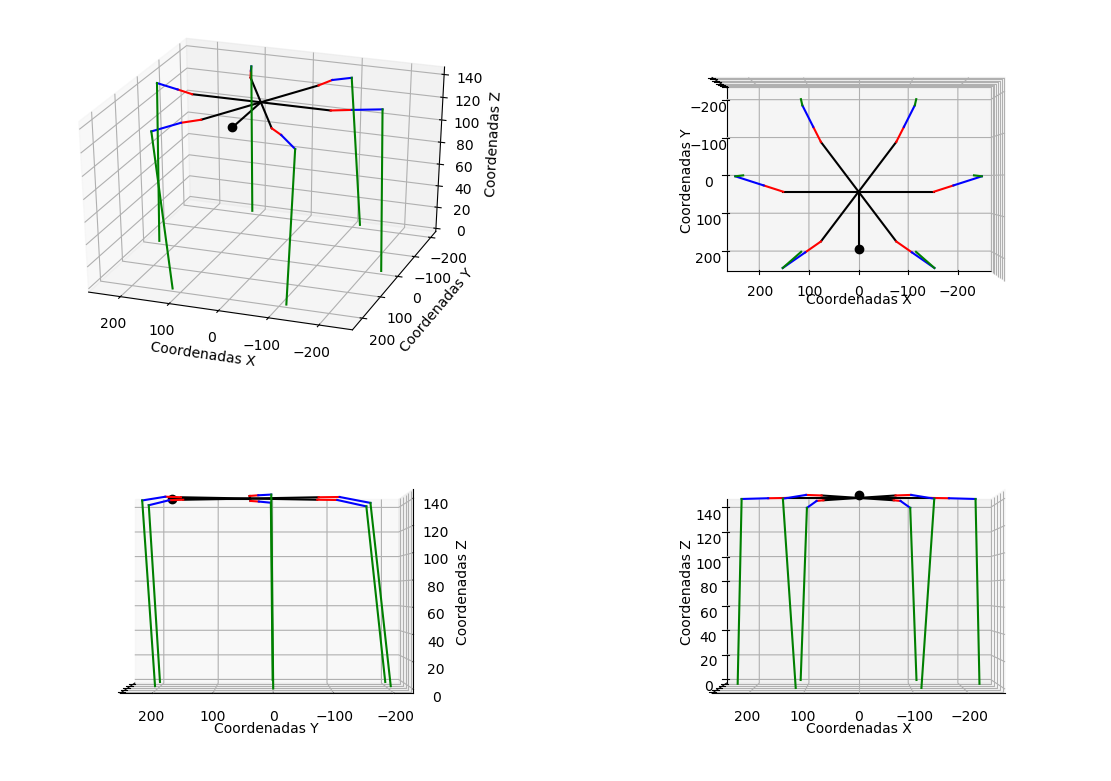


COORDENADAS X, Y, Z - COXA
[[ -97. -172.  -82.   82.  172.   97.]
 [ 185.   25. -115. -115.   25.  185.]
 [ 144.  144.  144.  144.  144.  144.]]

COORDENADAS X, Y, Z - FEMUR
[[-138. -224. -103.  103.  224.  138.]
 [ 222.    3. -167. -167.    3.  222.]
 [ 140.  143.  139.  139.  143.  140.]]

COORDENADAS X, Y, Z - TIBIA
[[-115. -232. -116.  116.  232.  115.]
 [ 202.   -0. -201. -201.   -0.  202.]
 [   0.    0.    0.    0.    0.    0.]]


In [618]:
from matplotlib.patches import Circle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d

# Creación de las figuras.
fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection='3d'), figsize=(14, 10), dpi=100, facecolor='w')

for axe in axes.flat :
    multiplots(axe, CoordFront.T, CoordStart_c, c='k', marker='o', markevery=2)
    multiplots(axe, CoordStart_c, CoordEnd_c, c='k')
    multiplots(axe, CoordEnd_c, CoordEnd_1, c='r')
    multiplots(axe, CoordEnd_1, CoordEnd_2, c='b')
    multiplots(axe, CoordEnd_2, CoordEnd_3, c='g')
    axe.set_xlabel(xlab); axe.set_ylabel(ylab); axe.set_zlabel(zlab)
    
# Configuración de las vistas
axes.flat[0].view_init(30, 110)
axes.flat[1].view_init(90, 90)
axes.flat[1].set_zlabel('')
axes.flat[1].set_zticklabels([])

axes.flat[2].view_init(0, 180)
axes.flat[2].set_xlabel('')
axes.flat[2].set_xticklabels([])

axes.flat[3].view_init(0, 90)
axes.flat[3].set_ylabel('')
axes.flat[3].set_yticklabels([])

# for i in range(6):
#     p = Circle((CoordEnd_c[0][i], CoordEnd_c[1][i]), lin_1, color = 'y', fill=False)
#     axes.flat[1].add_patch(p)
#     art3d.patch_2d_to_3d(p, z=z_init, zdir="z")

plt.show()

print("\n\033[1m" + "COORDENADAS X, Y, Z - COXA" + "\033[0m"); print(np.round(CoordEnd_1))
print("\n\033[1m" + "COORDENADAS X, Y, Z - FEMUR" + "\033[0m"); print(np.round(CoordEnd_2))
print("\n\033[1m" + "COORDENADAS X, Y, Z - TIBIA" + "\033[0m"); print(np.round(CoordEnd_3))